In [1]:
from tkinter import *
import numpy as np
import pandas as pd
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import heapq

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.models import load_model
from keras.utils.np_utils import to_categorical
import re

from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("bin_veri_kumesi.csv", sep=";") #pd.read_csv("Yuz_1.csv", sep=",")

In [3]:
df.head()

,Cumle,Sinif
0,Ay ise Alswider (esip geçen) adlı bir ata binm...,2
1,Yüzyıllardır yaşamı sona eren binlerce insana ...,1
2,Aynı anda binlerce sözcüğün beynimde patladığı...,1
3,Yüz binlerce insanın yaşadığı şehirde bir insa...,1
4,Binlerce sesin görüntünün ortasında en iyi pu...,1


In [4]:
data = df[['Cumle','Sinif']]

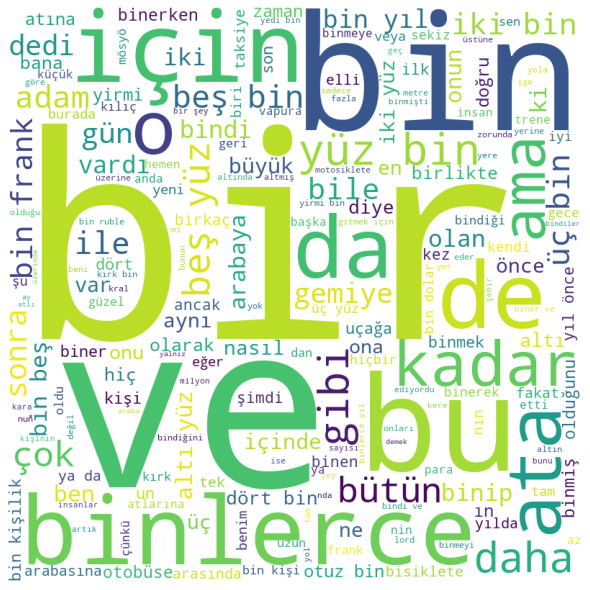

In [5]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in data["Cumle"]:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [6]:
# Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.
# Keras bu işlem için hazır bir mekanizma sunmaktadır.
# Tokenizer sınıfı data içerisinde verilen cümleleri analiz ederek. Kelimelerin sıklıklarını hesaplar.
# Parameter: num_words = En sık geçen 40000 kelimeye odaklan. Diğerleri önemli değil
tokenizer = Tokenizer(split=' ',num_words=40000)

In [7]:
# Her bir kelimenin sıklığını(frekansını) hesaplar.
tokenizer.fit_on_texts(data['Cumle'].values)
# Tüm cümleler tam sayı dizisine dönüştürülür.
X = tokenizer.texts_to_sequences(data['Cumle'].values)
# Bütün metinlerimiz 400 sütundan oluşan bir dizi ile temsil edilecek.
# Çok kısa metinler 0'lar ile doldurulacak. Çok uzun metinler ise kesilecek.
X = pad_sequences(X,maxlen=40)

In [8]:
T_df = pd.read_csv("Yuz_Test_1.csv", sep=",")
T_data = T_df[['Cumle','Sinif']]
T_data["Cumle"]
tokenizer.fit_on_texts(T_data['Cumle'].values)

TTT = tokenizer.texts_to_sequences(T_data['Cumle'].values)
TTT = pad_sequences(TTT,maxlen=40)
TY = pd.get_dummies(T_data['Sinif']).values

In [9]:
embed_dim = 128
lstm_out = 128
def build_model():
    model = Sequential()
    # Her bir kelimenin temsil edileceği vektör boyutu. Bu örnek için her bir kelime 128 boyutunda
    # bir vektör ile temsil edilir.
    model.add(Embedding(40000, embed_dim,input_length = X.shape[1], dropout=0.2))
    model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

# Çıktılarımızı kategorik hale getirdik. (Opsiyonel)
Y = pd.get_dummies(data['Sinif']).values

# Verinin %80'i train, %20'si test verisi olacak şekilde ayrılır.
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.7, random_state = 2)

In [10]:
modeller = [
    ('KNN',KNeighborsClassifier(n_neighbors=3,metric='cosine')),
    ('DTC',DecisionTreeClassifier())]

isimler = []
sonuclar = []
for isim,model in modeller:
    kfold = KFold(n_splits=10,shuffle=True, random_state=42)
    cv_sonuclar = cross_val_score(model,X_train,Y_train,cv=kfold,scoring='accuracy')
    isimler.append(isim)
    sonuclar.append(cv_sonuclar)
    print("Algoritma: %s / Başarım: %f / Std: %f" % (isim,cv_sonuclar.mean(),cv_sonuclar.std()))

Algoritma: KNN / Başarım: 0.603110 / Std: 0.048395
Algoritma: DTC / Başarım: 0.713110 / Std: 0.050742


In [11]:
from sklearn.metrics import f1_score
knn_cos =  RandomForestClassifier(max_depth=2, random_state=0)
knn_cos = knn_cos.fit(X_train,Y_train)
y_pred=knn_cos.predict(X_test)
print(" Accuary: ", accuracy_score(Y_test, y_pred))
print("F1: ",f1_score(Y_test,knn_cos.predict(X_test),average='weighted'))

 Accuary:  0.7184873949579832
F1:  0.7195384874666744


In [12]:
len(X_train)
#TTT

408

In [13]:
y_pred=knn_cos.predict(TTT)
y_pred

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)